In [15]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize, ndimage, stats, signal, fft
from skimage import filters, transform, morphology, exposure, measure, feature
from spikecounter.analysis import traces, images
from spikecounter.analysis import stats as sstats
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import parse
import importlib
import pickle
import seaborn as sns

# plt.style.use("../bio_pubs_presentation.mplstyle")
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

In [2]:
def reload_libraries():
    importlib.reload(utils)
    importlib.reload(visualize)
    importlib.reload(images)
    importlib.reload(traces)

In [3]:
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/v8"

1.5V = x mW/mm^2

In [4]:
V0 = 38e-3/(41499*7.048e-8)
um_per_px = 0.265*4
subfolder = "downsampled"
pad_t = 0.5
factor = 4

In [14]:
um_per_px

1.06

Steps
1. Load experiment info.
2. Select embryo.
3. Combine all targets into one mask.
4. Plot out traces for each video.
5. Separate into before, during, after stim.
6. Do peak detection.
7. Take Fourier transforms and identify peaks. Quantify shifts.

In [5]:
reload_libraries()

In [6]:
def get_split_dFFs(img, stim_edges, pad_t, dt, method="monoexp", img_mask=None,\
            nsamps=101,amplitude_window=1, remove_from_start=0.5):
    pad = int(np.ceil(pad_t/dt))

    delta = np.mean(np.array([img.astype(int)[stim_edges[0]+pad] - img.astype(int)[stim_edges[0]-pad],\
                              img.astype(int)[stim_edges[1]-pad] - img.astype(int)[stim_edges[1]+pad]]), axis=0)
    delta = np.maximum(delta, 0)
    if img_mask is None:
        mean_img = img[:stim_edges[0]-pad].mean(axis=0)

        img_mask = np.ones_like(mean_img)

#     before = images.correct_photobleach(img[:stim_edges[0]-pad], method=method,\
#                                     mask=img_mask, nsamps=nsamps)
#     during = images.correct_photobleach(img[stim_edges[0]+pad:stim_edges[1]-pad]\
#                                 - delta, method=method, mask=img_mask, nsamps=nsamps)
#     after = images.correct_photobleach(img[stim_edges[1]+pad:], method=method,\
#                                     mask=img_mask, nsamps=nsamps)
#     during = -images.correct_photobleach(-during, method=method,\
#                     mask=img_mask, invert=True)

    before = images.correct_photobleach(img[int(remove_from_start/dt):stim_edges[0]-pad], method=method,\
                                    mask=img_mask, nsamps=nsamps, amplitude_window=amplitude_window)
    
    after = images.correct_photobleach(img[stim_edges[1]+pad:], method=method,\
                                mask=img_mask, nsamps=nsamps, amplitude_window=amplitude_window)
    during, during_amplitude, params = images.correct_photobleach(img[stim_edges[0]+pad:stim_edges[1]-pad]\
                                - delta, method=method, mask=img_mask, nsamps=nsamps, return_params=True,\
                                                                  amplitude_window=amplitude_window)
#     mask2 = during_amplitude > np.percentile(during_amplitude, 80)
#     if np.all(mask2==0):
#         mask2 = img_mask
#     during, during_amplitude, params = images.correct_photobleach(img[stim_edges[0]+pad:stim_edges[1]-pad]\
#                                 - delta, method=method, mask=mask2, nsamps=nsamps, return_params=True,\
#                                                                   amplitude_window=amplitude_window)
#     during = -images.correct_photobleach(-during, method=method,\
#                     mask=img_mask, invert=True)
    
    return before, during, after

def split_snapt(rootdir, f, subfolder, tag=""):
    for k in ["before", "during", "after"]:
        try:
            sta = skio.imread(os.path.join(rootdir, "analysis", subfolder, f, "sta_%s%s.tif" % (tag,k)))
        except Exception as e:
            print(e)
            continue
        beta, smoothed_vid = images.spline_timing(sta, s=0.05, n_knots=15)
        skio.imsave(os.path.join(rootdir, "analysis", subfolder, \
                                 f, "spline_smoothed_vid_%s%s.tif" %(tag,k)), smoothed_vid)
        np.savez(os.path.join(rootdir, "analysis", subfolder, "%s_snapt_%s%s.npz") % (f,tag, k),\
                 beta=beta)


def default_mask(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(3))
    
    return np.ma.masked_array(Ts, nan_mask[1:-1,1:-1] |\
                                      (divergence < 0.5))

def mask2(Ts, divergence):
    nan_mask = morphology.binary_dilation(np.pad(np.isnan(Ts),1, constant_values=True), \
                                        footprint=morphology.disk(3))
    invalid = nan_mask[1:-1,1:-1] | (divergence < 0.5)
    invalid = morphology.binary_closing(invalid, footprint=morphology.disk(3))
    masked_Ts = np.ma.masked_array(Ts, invalid)
#     fig1, ax1 = plt.subplots(figsize=(6,6))
#     visualize.display_roi_overlay(Ts, ~invalid, ax=ax1)
    
    return masked_Ts

def correct_photobleach_gtacr(img, stim_edges, nsamps, offset_start=1, n_pad_before=-1, n_pad_after=1):
    img_crosstalk_corrected = np.copy(img)
    img_crosstalk_corrected[stim_edges[0]+offset_start:stim_edges[1]+n_pad_before] -= (img[stim_edges[1]+n_pad_before] -\
                                                img[stim_edges[1]+n_pad_after])
    img_crosstalk_corrected[stim_edges[1]+n_pad_before:stim_edges[1]+n_pad_after] -= (img[stim_edges[1]+\
                                                n_pad_before:stim_edges[1] + n_pad_after] - img[stim_edges[1]+n_pad_after])
    pb_corr_1 = images.correct_photobleach(img_crosstalk_corrected[:stim_edges[0]+offset_start], method="localmin", nsamps = nsamps)
    pb_corr_3, pb3 = images.correct_photobleach(img_crosstalk_corrected[stim_edges[1]:], method="localmin",\
                                                nsamps = nsamps, return_params=True)
    _, pb2 = images.correct_photobleach(img_crosstalk_corrected[stim_edges[0]+offset_start:stim_edges[1]], method="localmin",\
                                                nsamps = nsamps, return_params=True)
    pb_corr_2 = img_crosstalk_corrected[stim_edges[0]+offset_start:stim_edges[1]]/(pb2 - (pb2[-1] - pb3[0]))
    
    img_pb_corrected = np.concatenate([pb_corr_1, pb_corr_2, pb_corr_3], axis=0)
    return img_pb_corrected

In [7]:
experiments = ["20220212_gtacr_targeted_silencing",\
               "20220222_gtacr_targeted_silencing",\
               "20220301_gtacr_targeted_silencing",\
              "20220407_gtacr_silencing",\
              "20220628_gtacr_targeted_silencing"]

### Demo silencing

In [8]:
expt = experiments[2]
rootdir = os.path.join("/n/holyscratch01/cohen_lab/bjia/", expt)


In [9]:
files = ["114756gtacr_E4_target3_1.5V", "113246gtacr_E4_target1_0.7V"]
idx = 1

In [10]:
f1 = "114756gtacr_E4_target3_1.5V"
f2 = "113246gtacr_E4_target1_0.7V"
t_offset = 0

In [11]:
img, expt_data = images.load_image(rootdir, f1, subfolder="downsampled")
traces_dict, t = utils.traces_to_dict(expt_data)
stim_edges = np.argwhere(np.diff(traces_dict["enable488"].astype(int)) !=0).ravel() + t_offset
stim_edges_1 = np.copy(stim_edges)

factor = 4
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space'].astype(bool)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]

target_1 = np.copy(target_img_space)

img, expt_data = images.load_image(rootdir, f2, subfolder="downsampled")
traces_dict, t = utils.traces_to_dict(expt_data)
stim_edges = np.argwhere(np.diff(traces_dict["enable488"].astype(int)) !=0).ravel() + t_offset
stim_edges_2 = np.copy(stim_edges)

factor = 4
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space'].astype(bool)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]

target_2 = np.copy(target_img_space)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/downsampled/114756gtacr_E4_target3_1.5V/Sq_camera.bin'
[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/downsampled/113246gtacr_E4_target1_0.7V/Sq_camera.bin'


In [16]:
targets = [target_1, target_2]

In [12]:
img, expt_data = images.load_image(rootdir, files[idx], subfolder="downsampled")
img = img.astype(int)-100
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/downsampled/113246gtacr_E4_target1_0.7V/Sq_camera.bin'


In [13]:
dt

0.02053

In [105]:
img.shape

(2191, 216, 216)

In [106]:
stim_edges = np.argwhere(np.diff(traces_dict["enable488"].astype(int)) !=0).ravel() + t_offset

In [107]:
factor = 4
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space'].astype(bool)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]

In [85]:
mean_trace = img[t_offset:].mean(axis=(1,2))
target_trace = images.extract_mask_trace(img[t_offset:], mask=target_img_space)

In [38]:
pb_corr_test, pb = traces.correct_photobleach(mean_trace, method="localmin", nsamps = int(3/dt)+1)

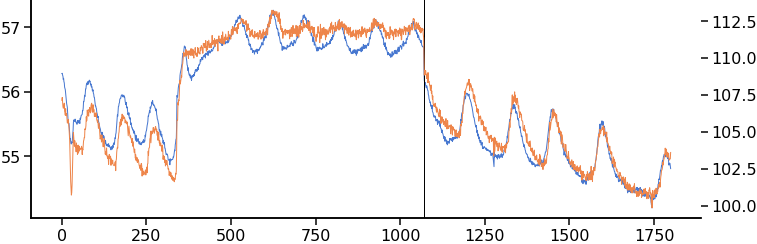

In [39]:
start_idx = 390
end_idx = -1
fig1, ax1 = plt.subplots(figsize=(12,4))
ax2 = ax1.twinx()
ax1.plot(mean_trace[start_idx:end_idx])
ax2.plot(target_trace[start_idx:end_idx], color="C1")
# ax1.axvline(stim_edges[0])
ax1.axvline(stim_edges[1]-start_idx, color="k")

In [40]:
img_crosstalk_corrected = np.copy(img[t_offset:])

In [41]:
pad_start = -1
pad_end = 1

In [42]:
img_crosstalk_corrected[stim_edges[0]+1:stim_edges[1]+pad_start] -= (img[stim_edges[1]+pad_start] - img[stim_edges[1]+pad_end])
img_crosstalk_corrected[stim_edges[1]+pad_start:stim_edges[1]+pad_end] -= (img[stim_edges[1]+pad_start:stim_edges[1]+pad_end] -\
                                            img[stim_edges[1]+pad_end])

In [43]:
img_crosstalk_corrected.shape

(2191, 216, 216)

In [44]:
mean_trace_ct = img_crosstalk_corrected.mean(axis=(1,2))
target_trace_ct_1 = images.extract_mask_trace(img_crosstalk_corrected, mask=target_1)
target_trace_ct_2 = images.extract_mask_trace(img_crosstalk_corrected, mask=target_2)

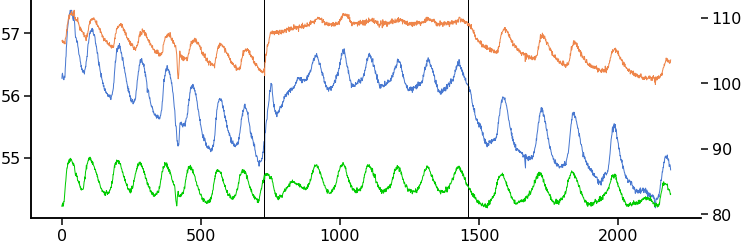

In [45]:
end_idx = -1
fig1, ax1 = plt.subplots(figsize=(12,4))
ax2 = ax1.twinx()
ax1.plot(mean_trace_ct[:end_idx])
ax2.plot(target_trace_ct_1[:end_idx], color="C1")
ax2.plot(target_trace_ct_2[:end_idx], color="C2")

# ax1.axvline(stim_edges[0])
ax1.axvline(stim_edges[1], color="k")
ax1.axvline(stim_edges[0], color="k")

In [46]:
pb_corr_test, pb = traces.correct_photobleach(mean_trace_ct, method="localmin", nsamps = int(3/dt)+1)

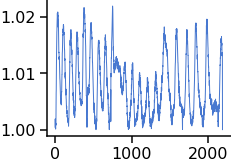

In [47]:
plt.plot(pb_corr_test)

In [48]:
offset = 1
pb_corr_1, pb1 = traces.correct_photobleach(mean_trace_ct[:stim_edges[0]+offset], method="localmin", nsamps = int(3/dt)+1)
pb_corr_3, pb3 = traces.correct_photobleach(mean_trace_ct[stim_edges[1]:], method="localmin", nsamps = int(3/dt)+1)
pb_corr_2, pb2 = traces.correct_photobleach(mean_trace_ct[stim_edges[0]+offset:stim_edges[1]], method="localmin", nsamps = int(3/dt)+1)
trace2_adj = mean_trace_ct[stim_edges[0]+offset:stim_edges[1]]/(pb2-(pb2[0]-pb3[0]))

In [49]:
corrected_trace = np.concatenate([pb_corr_1, trace2_adj, pb_corr_3])

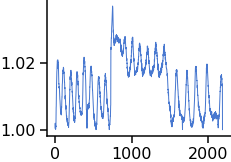

In [50]:
plt.plot(corrected_trace)

In [108]:
img_pb_corrected = correct_photobleach_gtacr(img[t_offset:], stim_edges.astype(int), int(3/dt)+1)

In [109]:
os.makedirs(os.path.join(rootdir, "aesthetic_video"), exist_ok=True)

In [53]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "pb_corr_test.tif"), exposure.rescale_intensity(img_pb_corrected, out_range=np.uint8))

In [110]:
k1 = 6
k2 = 20

In [111]:
dFF = images.get_image_dFF(img_pb_corrected, baseline_percentile=10, t_range=(0,200))

In [112]:
target_dff_1 = images.extract_mask_trace(dFF, mask=target_1)
target_pb_corr_1 = images.extract_mask_trace(img_pb_corrected, mask=target_1)

target_dff_2 = images.extract_mask_trace(dFF, mask=target_2)
target_pb_corr_2 = images.extract_mask_trace(img_pb_corrected, mask=target_2)


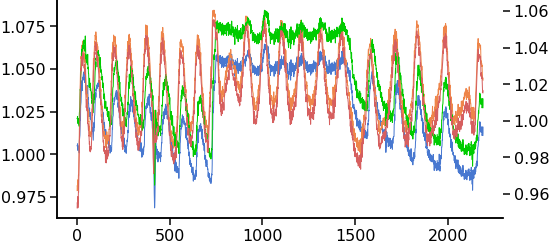

In [73]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(target_dff_1)
ax1.plot(target_dff_2)
ax2 = ax1.twinx()
ax2.plot(target_pb_corr_1, color="C2")
ax2.plot(target_pb_corr_2, color="C3")

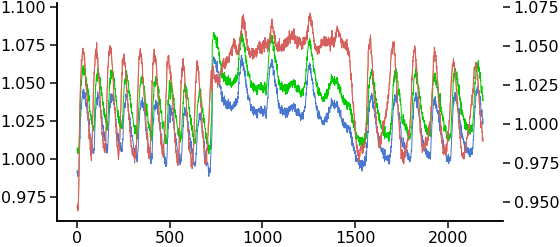

In [113]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(target_dff_1)
ax1.plot(target_dff_2)
ax2 = ax1.twinx()
ax2.plot(target_pb_corr_1, color="C2")
ax2.plot(target_pb_corr_2, color="C3")

In [124]:
idx = 0
dFF = skio.imread(os.path.join(rootdir, "aesthetic_video", "dFF_%d.tif"%(idx+1)))

In [125]:
dFF_filtered = ndimage.gaussian_filter(dFF, (1,k1,k1))

In [126]:
target_dff_1_filtered = images.extract_mask_trace(dFF_filtered, mask=target_1)
target_dff_2_filtered = images.extract_mask_trace(dFF_filtered, mask=target_2)


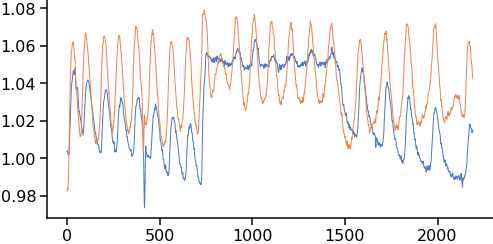

In [127]:
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(target_dff_1_filtered)
ax1.plot(target_dff_2_filtered)

In [128]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "dFF_%d.tif"%(idx+1)),dFF)

In [103]:
idx

1

In [59]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "dFF_smoothed%d_8bit.tif" %(idx+1)), exposure.rescale_intensity(dFF_filtered, out_range=np.uint8))

In [129]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "dFF_smoothed%d.tif"%(idx+1)),dFF_filtered)

/tmp/ipykernel_271164/1295603766.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/aesthetic_video/dFF_smoothed1.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "aesthetic_video", "dFF_smoothed%d.tif"%(idx+1)),dFF_filtered)


In [130]:
dFF1 = skio.imread(os.path.join(rootdir, "aesthetic_video", "dFF_smoothed1.tif"))
dFF2 = skio.imread(os.path.join(rootdir, "aesthetic_video", "dFF_smoothed2.tif"))

In [131]:
end_idx_1 = 1850
start_idx_2 = 390

In [132]:
dFF_concat = np.concatenate([dFF1[:end_idx_1], dFF2[start_idx_2:]], axis=0)

In [133]:
manual_mask = skio.imread(os.path.join(rootdir, "aesthetic_video", "manual_roi_map.tif"))

In [134]:
k3 = 15
apodized_mask = ndimage.gaussian_filter(manual_mask.astype(float), (k3,k3))

In [135]:
(dFF1*apodized_mask[None,:,:]).shape

(2191, 216, 216)

In [142]:
test_trace = images.extract_mask_trace(dFF_concat, manual_mask.astype(bool))

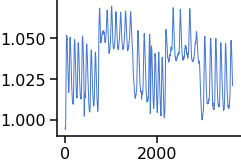

In [143]:
plt.plot(test_trace)

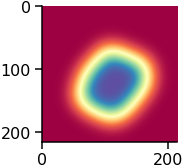

In [138]:
plt.imshow(apodized_mask)

In [252]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "video_dFF1.tif"), \
            (exposure.rescale_intensity(dFF1[:end_idx_1],in_range=(0.99, np.nanmax(dFF_concat)),\
                                        out_range=(0,255))*apodized_mask[None,:,:]).astype(np.uint8))
skio.imsave(os.path.join(rootdir, "aesthetic_video", "video_dFF2.tif"), \
            (exposure.rescale_intensity(dFF2[start_idx_2:],in_range=(0.99, np.nanmax(dFF_concat)),\
                                        out_range=(0,255))*apodized_mask[None,:,:]).astype(np.uint8))

In [139]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "dFF_full.tif"),\
            (exposure.rescale_intensity(dFF_concat,in_range=(0.99, np.nanmax(dFF_concat)), out_range=(0,255))*apodized_mask[None,:,:]).astype(np.uint8))

Perform arbitrary normalization

In [228]:
dFF1_norm = np.copy(dFF1)

In [229]:
pad_before = 2
pad_after = 58
dFF1_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after] /= np.nanpercentile(dFF1_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after], 10, axis=0)
dFF1_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after] /= np.nanpercentile(dFF1_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after], 10, axis=0)

In [230]:
test_trace = images.extract_mask_trace(dFF1_norm, manual_mask.astype(bool))

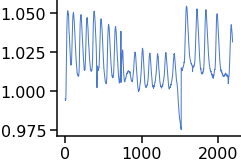

In [231]:
plt.plot(test_trace)

In [244]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "video_dFF1_norm.tif"),\
            (exposure.rescale_intensity(dFF1_norm[:end_idx_1],in_range=(0.99, max(np.nanmax(dFF1_norm), np.nanmax(dFF2_norm))), out_range=(0,255))*apodized_mask[None,:,:]).astype(np.uint8))

In [233]:
dFF2_norm = np.copy(dFF2)

In [234]:
pad_before = 2
pad_after = 58
dFF2_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after] /= np.nanpercentile(dFF2_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after], 10, axis=0)
dFF2_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after] /= np.nanpercentile(dFF2_norm[stim_edges_1[0]+pad_before:stim_edges_1[1]+pad_after], 10, axis=0)

In [235]:
test_trace = images.extract_mask_trace(dFF2_norm, manual_mask.astype(bool))

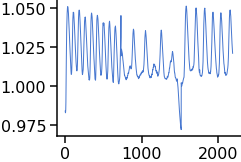

In [236]:
plt.plot(test_trace)

In [243]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "video_dFF2_norm.tif"),\
            (exposure.rescale_intensity(dFF2_norm[start_idx_2:],in_range=(0.99, max(np.nanmax(dFF1_norm), np.nanmax(dFF2_norm))), out_range=(0,255))*apodized_mask[None,:,:]).astype(np.uint8))

Draw targets and nkx reference

In [238]:
target_video_1 = np.zeros_like(dFF1, dtype=np.uint8)
target_video_2 = np.zeros_like(dFF2, dtype=np.uint8)

In [240]:
target_video_1[stim_edges_1[0]:stim_edges_1[1]] = target_1.astype(int)*255
target_video_2[stim_edges_2[0]:stim_edges_2[1]] = target_2.astype(int)*255


In [241]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_1.tif"), target_video_1[:end_idx_1])
skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_2.tif"), target_video_2[start_idx_2:])

/tmp/ipykernel_271164/1070551797.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/aesthetic_video/target_video_1.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_1.tif"), target_video_1[:end_idx_1])
/tmp/ipykernel_271164/1070551797.py:2: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/aesthetic_video/target_video_2.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_2.tif"), target_video_2[start_idx_2:])


In [325]:
target_video_concat = np.concatenate([target_video_1[:end_idx_1], target_video_2[start_idx_2:]], axis=0)

In [326]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_full.tif"), target_video_concat)

/tmp/ipykernel_205161/3552800822.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing/aesthetic_video/target_video_full.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "aesthetic_video", "target_video_full.tif"), target_video_concat)


In [246]:
nkx = skio.imread(os.path.join(rootdir, "aesthetic_video", "115015gtacr_E4_nkx.tiff"))

In [247]:
nkx = transform.downscale_local_mean(nkx, (4,4)).astype(np.uint16)

In [248]:
nkx_video = np.tile(nkx, (dFF_concat.shape[0], 1, 1))

In [323]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "nkx_video_full.tif"), exposure.rescale_intensity(nkx_video, out_range=np.uint8))

In [249]:
nkx_video_1 = np.tile(nkx, (target_video_1[:end_idx_1].shape[0], 1, 1))
nkx_video_2 = np.tile(nkx, (target_video_2[start_idx_2:].shape[0], 1, 1))


In [250]:
skio.imsave(os.path.join(rootdir, "aesthetic_video", "nkx_video_1.tif"), exposure.rescale_intensity(nkx_video_1, out_range=np.uint8))
skio.imsave(os.path.join(rootdir, "aesthetic_video", "nkx_video_2.tif"), exposure.rescale_intensity(nkx_video_2, out_range=np.uint8))

Make targets more visible

In [ ]:
for i in [1,2]:
    target_vid = skio.imread(os.path.join(rootdir, "aesthetic_video", "target_video_%d.tif" % i))
    rgb1 = skio.imread(os.path.join(rootdir, "aesthetic_video", "dFF%d_composite_RGB.tif" % i))
    
    break
    rgb2 = skio.imread(os.path.join(rootdir, "aesthetic_video", "dFF%d_norm_composite_RGB.tif" % i))
    
    rgb1[target_vid] = np.array([0,0,255])[None,None,None,:]
    rgb2[target_vid] = np.array([0,0,255])[None,None,None,:]

2091
$3\%$
$\Delta F/F$
2091


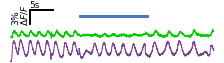

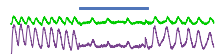

In [10]:
plt.close("all")


# embryo = 3
# f1 = "121100gtacr_E3_target3_2V"
# roi1 = 2
# f2 = "120840gtacr_E3_target2_2V"
# roi2 = 1


f1 = "114756gtacr_E4_target3_1.5V"
roi1 = 2
f2 = "113246gtacr_E4_target1_0.7V"
roi2 = 0
rep_traces = []




dFFs_1 = embryo_data["trace_data"][f1]["dFFs"]
dFFs_2 = embryo_data["trace_data"][f2]["dFFs"]
dt = np.mean(np.diff(embryo_data["trace_data"][f1]["t"]))

fig1, ax1 = plt.subplots(figsize=(4,1))
tr1 = np.concatenate([dFFs_1["before"][roi1], dFFs_1["during"][roi1],\
                    dFFs_1["after"][roi1]])
tr2 = np.concatenate([dFFs_1["before"][roi2], dFFs_1["during"][roi2],\
                    dFFs_1["after"][roi2]])

ax1.plot(dt*np.arange(len(tr1)), tr1-1+0.04, color="C2")
ax1.plot(dt*np.arange(len(tr2)), tr2-1, color="#79438e")
print(len(tr2))
ax1.set_ylim(-0.015, 0.1)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
scalebar_params = {
    "corner_x": xlim[0]+6,
    "corner_y": ylim[1]*0.95,
    "ampl_scale": 0.03,
    "time_scale": 5,
    "fontsize": 9,
    "thickness": ylim[1]*0.02,
    "xlabel_offset_y": 0.006,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -4,
    "ylabel_offset_y": 0.003
    }
visualize.plot_scalebars(ax1, scalebar_params, pct_f=True)
visualize.plot_img_scalebar(fig1, ax1, 14.5, 0.08, 14.5, 0.005,\
              yax_direction="up", color="#5076BA", show_label=False)
plt.savefig(os.path.join(figdir, "Figure4", "silencing_non_loi_example_traces.svg"))
# tr2 = np.concatenate([dFFs_2["before"], dFFs_2["during"], dFFs_2["after"]])

fig1, ax1 = plt.subplots(figsize=(4,1))
ax1.set_ylim(-0.015, 0.1)
tr1 = np.concatenate([dFFs_2["before"][roi1], dFFs_2["during"][roi1],\
                    dFFs_2["after"][roi1]])
tr2 = np.concatenate([dFFs_2["before"][roi2], dFFs_2["during"][roi2],\
                    dFFs_2["after"][roi2]])
ax1.plot(dt*np.arange(len(tr1)), tr1-1+0.05, color="C2")
ax1.plot(dt*np.arange(len(tr2)), tr2-1, color="#79438e")
print(len(tr2))
ax1.set_axis_off()
visualize.plot_img_scalebar(fig1, ax1, 14.5, 0.08, 14.5, 0.005,\
              yax_direction="up", color="#5076BA", show_label=False)
plt.savefig(os.path.join(figdir, "Figure4", "silencing_loi_example_traces.svg"))

2091
$3\%$
$\Delta F/F$
2091


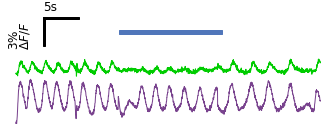

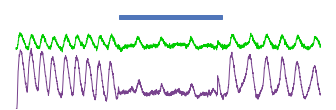

In [41]:
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    plt.close("all")


    # embryo = 3
    # f1 = "121100gtacr_E3_target3_2V"
    # roi1 = 2
    # f2 = "120840gtacr_E3_target2_2V"
    # roi2 = 1


    f1 = "114756gtacr_E4_target3_1.5V"
    roi1 = 2
    f2 = "113246gtacr_E4_target1_0.7V"
    roi2 = 0
    rep_traces = []




    dFFs_1 = embryo_data["trace_data"][f1]["dFFs"]
    dFFs_2 = embryo_data["trace_data"][f2]["dFFs"]
    dt = np.mean(np.diff(embryo_data["trace_data"][f1]["t"]))

    fig1, ax1 = plt.subplots(figsize=(6,2))
    tr1 = np.concatenate([dFFs_1["before"][roi1], dFFs_1["during"][roi1],\
                        dFFs_1["after"][roi1]])
    tr2 = np.concatenate([dFFs_1["before"][roi2], dFFs_1["during"][roi2],\
                        dFFs_1["after"][roi2]])

    ax1.plot(dt*np.arange(len(tr1)), tr1-1+0.04, color="C2")
    ax1.plot(dt*np.arange(len(tr2)), tr2-1, color="#79438e")
    print(len(tr2))
    ax1.set_ylim(-0.015, 0.1)
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    scalebar_params = {
        "corner_x": xlim[0]+6,
        "corner_y": ylim[1]*0.96,
        "ampl_scale": 0.03,
        "time_scale": 5,
        "fontsize": 12,
        "thickness": ylim[1]*0.02,
        "xlabel_offset_y": 0.01,
        "xlabel_offset_x": 0,
        "ylabel_offset_x": -5,
        "ylabel_offset_y": 0.002
        }
    visualize.plot_scalebars(ax1, scalebar_params, pct_f=True)
    visualize.plot_img_scalebar(fig1, ax1, 14.5, 0.08, 14.5, 0.005,\
                  yax_direction="up", color="#5076BA", show_label=False)
    plt.savefig(os.path.join(figdir, "Figure4", "POSTER_silencing_non_loi_example_traces.svg"))
    # tr2 = np.concatenate([dFFs_2["before"], dFFs_2["during"], dFFs_2["after"]])

    fig1, ax1 = plt.subplots(figsize=(6,2))
    ax1.set_ylim(-0.015, 0.1)
    tr1 = np.concatenate([dFFs_2["before"][roi1], dFFs_2["during"][roi1],\
                        dFFs_2["after"][roi1]])
    tr2 = np.concatenate([dFFs_2["before"][roi2], dFFs_2["during"][roi2],\
                        dFFs_2["after"][roi2]])
    ax1.plot(dt*np.arange(len(tr1)), tr1-1+0.05, color="C2")
    ax1.plot(dt*np.arange(len(tr2)), tr2-1, color="#79438e")
    print(len(tr2))
    ax1.set_axis_off()
    visualize.plot_img_scalebar(fig1, ax1, 14.5, 0.08, 14.5, 0.005,\
                  yax_direction="up", color="#5076BA", show_label=False)
    plt.savefig(os.path.join(figdir, "Figure4", "POSTER_silencing_loi_example_traces.svg"))

In [11]:
# colormap for edges of ROI 1
cmatrix = np.zeros((3,2,3))
cmatrix[:,1,0] = 1
cmatrix[:,0,1:3] = np.array([0,0,0])[:,None]/255
cmatrix[:,1,1:3] = np.array([0,204,0])[:,None]/255

cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

cmp1 = colors.LinearSegmentedColormap('testCmap1', segmentdata=cdict, N=256)

In [12]:
# colormap for edges of ROI 1
cmatrix = np.zeros((3,2,3))
cmatrix[:,1,0] = 1
cmatrix[:,0,1:3] = np.array([0,0,0])[:,None]/255
cmatrix[:,1,1:3] = np.array([121,67,142])[:,None]/255

cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

cmp2 = colors.LinearSegmentedColormap('testCmap2', segmentdata=cdict, N=256)

In [13]:
strel = morphology.disk(6)

In [16]:
target_mask1 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f1]["target"]]).astype(float)
target_mask1[target_mask1==0] = np.nan
target_mask2 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f2]["target"]]).astype(float)
target_mask2[target_mask2==0] = np.nan

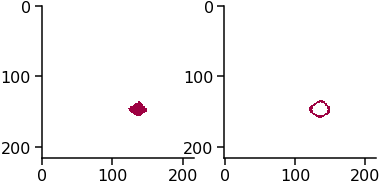

In [17]:
edges1 = feature.canny(np.nan_to_num(target_mask1), sigma=2)
edges1 = morphology.binary_closing(edges1, footprint=strel)
edges1 = morphology.binary_dilation(edges1, footprint=morphology.disk(1))
# edges2 = edges2.astype(float)
fig1, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(target_mask1)
edges1 = np.ma.masked_array(edges1, mask=~edges1)
axes[1].imshow(edges1, interpolation='none')

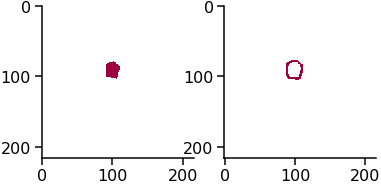

In [18]:
edges2 = feature.canny(np.nan_to_num(target_mask2), sigma=2)
edges2 = morphology.binary_closing(edges2, footprint=strel)
edges2 = morphology.binary_dilation(edges2, footprint=morphology.disk(1))
# edges2 = edges2.astype(float)
fig1, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(target_mask2)
edges2 = np.ma.masked_array(edges2, mask=~edges2)
axes[1].imshow(edges2, interpolation='none')


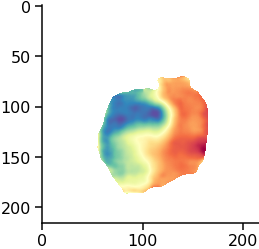

In [30]:
plt.imshow(isochrones[idx]-np.nanpercentile(isochrones[idx], 2))

In [38]:
reload_libraries()

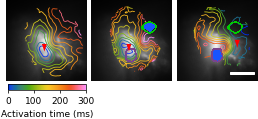

In [23]:
%matplotlib inline
vmax = 300
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):
    f1 = "114756gtacr_E4_target3_1.5V"
    roi1 = 2
    f2 = "113246gtacr_E4_target1_0.7V"
    roi2 = 0
    
    fig1, axes = plt.subplots(1,3, figsize=(4.5,1.5), gridspec_kw={"wspace": 0.05})
    isochrones = [embryo_data["trace_data"][f2]["before"]["smoothed_t"],
                 embryo_data["trace_data"][f1]["during"]["smoothed_t"],
                 embryo_data["trace_data"][f2]["during"]["smoothed_t"]]
    lois = [embryo_data["trace_data"][f2]["before"]["loi"],
                 embryo_data["trace_data"][f1]["during"]["loi"],
                 embryo_data["trace_data"][f2]["during"]["loi"]]

    target_mask1 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f1]["target"]]).astype(float)
    target_mask1[target_mask1==0] = np.nan
    target_mask2 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f2]["target"]]).astype(float)
    target_mask2[target_mask2==0] = np.nan

    for idx, ax in enumerate(axes):
        ax.imshow(embryo_data["snap"], cmap="gray")
        q =axes[idx].contour(isochrones[idx]-np.nanpercentile(isochrones[idx], 2),\
                                        levels=np.linspace(0, vmax, 10), cmap="cet_CET_R1")
        axes[idx].set_axis_off()
        loi = lois[idx]
        triangle_point = [loi[0], loi[1]]
        triangle_width = 10
        triangle_height = 15
        mark = patches.Polygon(np.array([triangle_point,\
                               [triangle_point[0]-triangle_width/2,triangle_point[1]+triangle_height],\
                               [triangle_point[0]+triangle_width/2,triangle_point[1]+triangle_height]]),\
                              edgecolor=None, facecolor="red", zorder=6)
        axes[idx].add_patch(mark)
        x0 = 20
        y0 = 40
        size = 160
        axes[idx].set_xlim((x0, x0+size))
        axes[idx].set_ylim((y0+size, y0))
        axes[idx].invert_yaxis()


    axes[1].imshow(target_mask1, alpha=1, \
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    axes[1].imshow(edges1,interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=5)

    axes[1].imshow(edges2,interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=4)
    axes[2].imshow(target_mask2, alpha=1,\
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    
    axes[2].imshow(edges1,interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=4)

    axes[2].imshow(edges2,interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=5)
    norm = mpl.colors.Normalize(vmin=0, \
                   vmax=vmax)
    cax = plt.axes([0.13, 0.05, 0.24, 0.05])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=q.cmap, norm=norm, orientation="horizontal")
    cb1.set_label("Activation time (ms)")
    cb1.set_ticks(np.linspace(0, vmax, 4))
    visualize.plot_img_scalebar(fig1, axes[2], 115 + x0-10, y0+14, 50, 4, pix_per_um = 1/um_per_px, fontsize=9, \
                      color="white", unit="\mu m", yax_direction="up", \
                    text_pos="below", scale=0.73,  show_label=False)
plt.savefig(os.path.join(figdir, "Figure4", "silencing_isochrons.tif"), dpi=300)

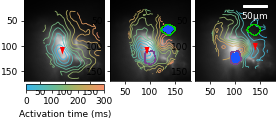

In [26]:
%matplotlib inline
vmax = 300
with plt.style.context("/n/home11/bjia/bio_publications.mplstyle"):
    f1 = "114756gtacr_E4_target3_1.5V"
    roi1 = 2
    f2 = "113246gtacr_E4_target1_0.7V"
    roi2 = 0
    
    fig1, axes = plt.subplots(1,3, figsize=(4.5,1.5), gridspec_kw={"wspace": 0.05})
    isochrones = [embryo_data["trace_data"][f2]["before"]["smoothed_t"],
                 embryo_data["trace_data"][f1]["during"]["smoothed_t"],
                 embryo_data["trace_data"][f2]["during"]["smoothed_t"]]
    lois = [embryo_data["trace_data"][f2]["before"]["loi"],
                 embryo_data["trace_data"][f1]["during"]["loi"],
                 embryo_data["trace_data"][f2]["during"]["loi"]]

    target_mask1 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f1]["target"]]).astype(float)
    target_mask1[target_mask1==0] = np.nan
    target_mask2 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f2]["target"]]).astype(float)
    target_mask2[target_mask2==0] = np.nan

    for idx, ax in enumerate(axes):
        ax.imshow(np.flipud(embryo_data["snap"]), cmap="gray")
        q =axes[idx].contour(np.flipud(isochrones[idx]-np.nanpercentile(isochrones[idx], 2)),\
                                        levels=np.linspace(0, vmax, 10), cmap="cet_CET_I1")
#         axes[idx].set_axis_off()
        loi = lois[idx]
        triangle_point = [loi[0], isochrones[idx].shape[0] - loi[1]]
        triangle_width = 10
        triangle_height = 15
        mark = patches.Polygon(np.array([triangle_point,\
                               [triangle_point[0]-triangle_width/2,triangle_point[1]-triangle_height],\
                               [triangle_point[0]+triangle_width/2,triangle_point[1]-triangle_height]]),\
                              edgecolor=None, facecolor="red", zorder=6)
        axes[idx].add_patch(mark)
        x0 = 20
        y0 = 10
        size = 160
        axes[idx].set_xlim((x0, x0+size))
        axes[idx].set_ylim((y0+size, y0))

    axes[1].imshow(np.flipud(target_mask1), alpha=1, \
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    axes[1].imshow(np.flipud(edges1),interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=5)

    axes[1].imshow(np.flipud(edges2),interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=4)
    axes[2].imshow(np.flipud(target_mask2), alpha=1,\
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    
    axes[2].imshow(np.flipud(edges1),interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=4)

    axes[2].imshow(np.flipud(edges2),interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=5)
    norm = mpl.colors.Normalize(vmin=0, \
                   vmax=vmax)
    cax = plt.axes([0.13, 0.05, 0.24, 0.05])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=q.cmap, norm=norm, orientation="horizontal")
    cb1.set_label("Activation time (ms)")
    cb1.set_ticks(np.linspace(0, vmax, 4))
    visualize.plot_img_scalebar(fig1, axes[2], 115 + x0-20, 20, 50, 4, pix_per_um = 1/um_per_px, fontsize=9, \
                      color="white", unit="\mu m", yax_direction="down", \
                    text_pos="above", scale=1,  show_label=True)
#     plt.savefig(os.path.join(figdir, "Figure4", "silencing_isochrons.tif"), dpi=300)

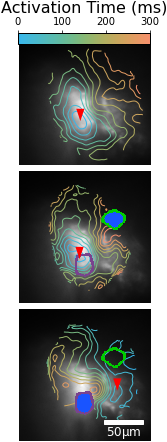

In [36]:
vmax = 300
plt.close("all")
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, axes = plt.subplots(3,1, figsize=(3,7.5), gridspec_kw={"hspace": 0.05})
    isochrones = [embryo_data["trace_data"][f2]["before"]["smoothed_t"],
                 embryo_data["trace_data"][f1]["during"]["smoothed_t"],
                 embryo_data["trace_data"][f2]["during"]["smoothed_t"]]
    lois = [embryo_data["trace_data"][f2]["before"]["loi"],
                 embryo_data["trace_data"][f1]["during"]["loi"],
                 embryo_data["trace_data"][f2]["during"]["loi"]]

    target_mask1 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f1]["target"]]).astype(float)
    target_mask1[target_mask1==0] = np.nan
    target_mask2 = np.copy(embryo_data["unique_targets"][embryo_data["trace_data"][f2]["target"]]).astype(float)
    target_mask2[target_mask2==0] = np.nan

    for idx, ax in enumerate(axes):
        ax.imshow(np.flipud(embryo_data["snap"]), cmap="gray")
        q =axes[idx].contour(np.flipud(isochrones[idx]-np.nanpercentile(isochrones[idx], 2)),\
                                        levels=np.linspace(0, vmax, 10), cmap="cet_CET_I1")
        axes[idx].set_axis_off()
        loi = lois[idx]
        triangle_point = [loi[0], isochrones[idx].shape[0] - loi[1]]
        triangle_width = 10
        triangle_height = 15
        mark = patches.Polygon(np.array([triangle_point,\
                               [triangle_point[0]-triangle_width/2,triangle_point[1]-triangle_height],\
                               [triangle_point[0]+triangle_width/2,triangle_point[1]-triangle_height]]),\
                              edgecolor=None, facecolor="red", zorder=6)
        axes[idx].add_patch(mark)
        x0 = 20
        y0 = 10
        size = 160
        axes[idx].set_xlim((x0, x0+size))
        axes[idx].set_ylim((y0+size, y0))

    axes[1].imshow(np.flipud(target_mask1), alpha=1, \
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    axes[1].imshow(np.flipud(edges1),interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=5)

    axes[1].imshow(np.flipud(edges2),interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=4)
    axes[2].imshow(np.flipud(target_mask2), alpha=1,\
                   cmap="cet_CET_L15", vmin=0, vmax=1, zorder=4)
    
    axes[2].imshow(np.flipud(edges1),interpolation='none', cmap=cmp1, vmin=0,vmax=1, zorder=4)

    axes[2].imshow(np.flipud(edges2),interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=5)
    norm = mpl.colors.Normalize(vmin=0, \
                   vmax=vmax)
    cax = plt.axes([0.205, 0.86, 0.61, 0.020])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=q.cmap, norm=norm, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    cb1.set_label("Activation Time (ms)")
    cb1.set_ticks(np.linspace(0, vmax, 4))
    visualize.plot_img_scalebar(fig1, axes[2], 124 + x0-20, 145 + y0-10, 50, 4, pix_per_um = 1/um_per_px, fontsize=12, \
                      color="white", unit="\mu m", yax_direction="down", \
                    text_pos="above", scale=1,  show_label=True)
    plt.savefig(os.path.join(figdir, "Figure4", "POSTER_silencing_isochrons.tif"), dpi=600)

In [24]:
np.unique(edges1)

array([False,  True])

### Notes

20220212
* E4 - not useable
* E6 - not useable

20220222
* E16 not useable
* E17 not useable
* E18 works but somewhat challeng
* E8 target 2 best

20220301
* E12 did not work
* E4 good
* E3 good

20220407
* E2 did not work
* E1 sort of worked?
* E6 did not work
* E7 good
* E8 maybe good?

In [ ]:
rootdir = os.path.join("/n/holyscratch01/cohen_lab/bjia/", experiments[3])
embryo = 2
with open(os.path.join(rootdir, "analysis", "E%s.pickle" % str(embryo)), "rb") as f:
    embryo_data = pickle.load(f)

snap = embryo_data["snap"]
f = "093950E2_target1_silence_4V_larger"
os.makedirs(os.path.join(rootdir, "analysis", "downsampled", f), exist_ok=True)
img, expt_data = images.load_image(rootdir, f, subfolder="downsampled")

dFFs = embryo_data["trace_data"][f]["dFFs"]
stim_edges = embryo_data["trace_data"][f]["stim_edges"]
dt = np.mean(np.diff(embryo_data["trace_data"][f]["t"]))
pad = int(np.ceil(pad_t/dt))
sos = signal.butter(9, (0.1, 1.5), btype='band', output='sos', fs=1/dt)

delta = np.mean(np.array([img.astype(int)[stim_edges[0]+pad] - img.astype(int)[stim_edges[0]-pad],\
                          img.astype(int)[stim_edges[1]-pad] - img.astype(int)[stim_edges[1]+pad]]), axis=0)
delta = np.maximum(delta, 0)
try:
    img_mask = snap > np.percentile(snap, 80)
except Exception as e:
    mean_img = img[:stim_edges[0]-pad].mean(axis=0)
    img_mask = mean_img > np.percentile(mean_img, 80)
split_images = {"before": images.get_image_dFF(images.correct_photobleach(img[:stim_edges[0]-pad], method="monoexp",\
                                mask=img_mask)),
                "during": images.get_image_dFF(images.correct_photobleach(img[stim_edges[0]+pad:stim_edges[1]-pad]\
                            - delta, method="monoexp", mask=img_mask)),
               "after": images.get_image_dFF(images.correct_photobleach(img[stim_edges[1]+pad:], method="monoexp",\
                                mask=img_mask))}

In [ ]:
skio.imsave(os.path.join(rootdir, "analysis", "downsampled", f, "dFF_during.tif"), split_images["during"])